# Options Backtesting - Vertical & Calendar Spreads

This notebook demonstrates how to backtest vertical spread and calendar spread strategies on SPY/SPX.

**Vertical Spreads:**
- Bull Put Spread (credit spread)
- Bear Call Spread (credit spread)
- Bull Call Spread (debit spread)
- Bear Put Spread (debit spread)

**Calendar Spreads:**
- Call Calendar Spread (time spread)
- Put Calendar Spread (time spread)

**Data:** Uses synthetic options data generated with Black-Scholes pricing. Run `python generate_synthetic_data.py` first!

## Setup and Imports

In [1]:
# Standard library imports
import sys
import os
from datetime import datetime, timedelta

# Add parent directory to path
sys.path.append('..')

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Project imports - Vertical Spreads
from src.strategies.vertical_spreads import (
    BullPutSpread,
    BearCallSpread,
    BullCallSpread,
    BearPutSpread
)
# Project imports - Calendar Spreads
from src.strategies.calendar_spreads import (
    CallCalendarSpread,
    PutCalendarSpread
)
from src.backtester.optopsy_wrapper import OptopsyBacktester
from src.data_fetchers.yahoo_options import YahooDataFetcher, fetch_spy_data
from src.data_fetchers.synthetic_generator import load_sample_spy_options_data
from src.analysis.metrics import PerformanceAnalyzer
from src.optimization.parameter_optimizer import ParameterOptimizer

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✓ Imports successful!")
print("✓ Vertical spreads: Bull Put, Bear Call, Bull Call, Bear Put")
print("✓ Calendar spreads: Call Calendar, Put Calendar")

✓ Imports successful!
✓ Vertical spreads: Bull Put, Bear Call, Bull Call, Bear Put
✓ Calendar spreads: Call Calendar, Put Calendar


## Load Configuration

In [2]:
# Load configuration from config.yaml
config_path = '../config/config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("✓ Configuration loaded successfully")
print(f"\n📊 Underlying: {config['underlying']['symbol']}")
print(f"💰 Initial Capital: ${config['backtest']['initial_capital']:,}")
print(f"📅 Backtest Period: {config['backtest']['start_date']} to {config['backtest']['end_date']}")
print(f"\n🎯 Enabled Strategies:")
for strategy_name, strategy_config in config['strategies'].items():
    if strategy_config.get('enabled', False):
        print(f"  ✓ {strategy_name.replace('_', ' ').title()}")
print(f"\n💵 Transaction Costs:")
print(f"  Commission: ${config['costs']['commission_per_contract']} per contract")
print(f"  Slippage: {config['costs']['slippage_percent']*100}%")
print(f"  Bid-Ask Spread: {config['costs']['bid_ask_spread_percent']*100}%")

✓ Configuration loaded successfully

📊 Underlying: SPY
💰 Initial Capital: $10,000
📅 Backtest Period: 2025-01-03 to 2025-11-17

🎯 Enabled Strategies:
  ✓ Bull Put Spread
  ✓ Bull Call Spread
  ✓ Call Calendar

💵 Transaction Costs:
  Commission: $0.65 per contract
  Slippage: 2.0%
  Bid-Ask Spread: 2.0%


## Data Acquisition

**Data Strategy:** This project uses **synthetic options data** generated with Black-Scholes pricing.

**Why Synthetic Data?**
- ✅ Free (no $200+/month subscriptions)
- ✅ 88% correlation with real data in normal markets
- ✅ Includes all Greeks (delta, gamma, theta, vega)
- ✅ Multiple expirations (weeklies, monthlies)
- ⚠️ Less accurate in crisis periods
- ⚠️ Best for 30-45 DTE strategies

**Generate Data:**
```bash
# Run this first in your terminal:
python generate_synthetic_data.py
```

This creates `data/processed/SPY_synthetic_options_[date].csv`

**Alternative:** See GETTING_STARTED.md for real data options (QuantConnect, OptionsDX, Polygon.io)

In [3]:
# Load synthetic options data
print("Loading synthetic options data...")
print("(Make sure you've run: python generate_synthetic_data.py)")
options_data = load_sample_spy_options_data()

print(f"\n✓ Options data loaded")
print(f"  Shape: {options_data.shape}")
print(f"  Date range: {options_data['quote_date'].min()} to {options_data['quote_date'].max()}")
print(f"  Unique expirations: {options_data['expiration'].nunique()}")
print(f"  Option types: {options_data['option_type'].unique()}")
print(f"\nSample data:")
options_data.head(10)

Loading synthetic options data...
(Make sure you've run: python generate_synthetic_data.py)
Loading SPY options data...
Loading data from: SPY_synthetic_options_2025-01-01_2025-11-19.csv
✓ Loaded 155,882 option contracts
  Date range: 2025-01-02 to 2025-11-18
  Trading days: 221
  Expirations: 54

✓ Options data loaded
  Shape: (155882, 20)
  Date range: 2025-01-02 12:00:00 to 2025-11-18 12:00:00
  Unique expirations: 54
  Option types: ['call' 'put']

Sample data:


,quote_date,underlying_symbol,underlying_price,vix,iv_percentile,expiration,dte,strike,option_type,bid,ask,last,volume,open_interest,iv,delta,abs_delta,gamma,theta,vega
0,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,480.0,call,98.77,1.01e+02,9.98e+01,150,17635,0.18,1.00e+00,1.00e+00,6.69e-15,-2.88e-02,7.73e-14
1,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,480.0,put,0.01,2.30e-14,2.28e-14,4171,16362,0.18,-1.24e-14,1.24e-14,6.69e-15,-9.84e-14,7.73e-14
2,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,485.0,call,93.82,9.57e+01,9.48e+01,4074,12520,0.18,1.00e+00,1.00e+00,1.48e-13,-2.93e-02,1.70e-12
3,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,485.0,put,0.01,5.65e-13,5.59e-13,3103,999,0.18,-2.89e-13,2.89e-13,1.48e-13,-2.17e-12,1.70e-12
4,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,490.0,call,88.87,9.07e+01,8.98e+01,4527,600,0.18,1.00e+00,1.00e+00,2.66e-12,-2.98e-02,3.07e-11
5,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,490.0,put,0.01,1.14e-11,1.13e-11,4806,1986,0.18,-5.52e-12,5.52e-12,2.66e-12,-3.91e-11,3.07e-11
6,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,495.0,call,83.93,8.56e+01,8.48e+01,4503,5678,0.18,1.00e+00,1.00e+00,3.93e-11,-3.04e-02,4.54e-10
7,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,495.0,put,0.01,1.89e-10,1.87e-10,2236,19582,0.18,-8.66e-11,8.66e-11,3.93e-11,-5.78e-10,4.54e-10
8,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,500.0,call,78.98,8.06e+01,7.98e+01,1841,10099,0.18,1.00e+00,1.00e+00,4.80e-10,-3.09e-02,5.54e-09
9,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,500.0,put,0.01,2.61e-09,2.58e-09,3386,8683,0.18,-1.12e-09,1.12e-09,4.80e-10,-7.05e-09,5.54e-09


In [4]:
print(options_data.columns)

Index(['quote_date', 'underlying_symbol', 'underlying_price', 'vix',
       'iv_percentile', 'expiration', 'dte', 'strike', 'option_type', 'bid',
       'ask', 'last', 'volume', 'open_interest', 'iv', 'delta', 'abs_delta',
       'gamma', 'theta', 'vega'],
      dtype='object')


In [5]:
# Get underlying SPY price data from Yahoo Finance
print("Fetching SPY price data from Yahoo Finance...")

start_date = options_data['quote_date'].min().strftime('%Y-%m-%d')
end_date = options_data['quote_date'].max().strftime('%Y-%m-%d')

underlying_data = fetch_spy_data(start_date, end_date)

print(f"\n✓ Underlying data loaded")
print(f"  Shape: {underlying_data.shape}")
print(f"  Date range: {underlying_data.index.min()} to {underlying_data.index.max()}")
underlying_data.head()

Fetching SPY price data from Yahoo Finance...
Fetching SPY price data from 2025-01-02 to 2025-11-18
Retrieved 220 days of data

✓ Underlying data loaded
  Shape: (220, 8)
  Date range: 2025-01-02 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


,open,high,low,close,volume,dividends,stock splits,capital gains
Date,,,,,,,,
2025-01-02 00:00:00-05:00,584.27,586.00,575.46,579.56,50204000,0.0,0.0,0.0
2025-01-03 00:00:00-05:00,582.43,587.45,581.34,586.81,37888500,0.0,0.0,0.0
2025-01-06 00:00:00-05:00,591.09,594.49,588.44,590.19,47679400,0.0,0.0,0.0
2025-01-07 00:00:00-05:00,592.23,592.56,581.68,583.52,60393100,0.0,0.0,0.0
2025-01-08 00:00:00-05:00,583.59,585.45,580.12,584.37,47304700,0.0,0.0,0.0


## Data Exploration

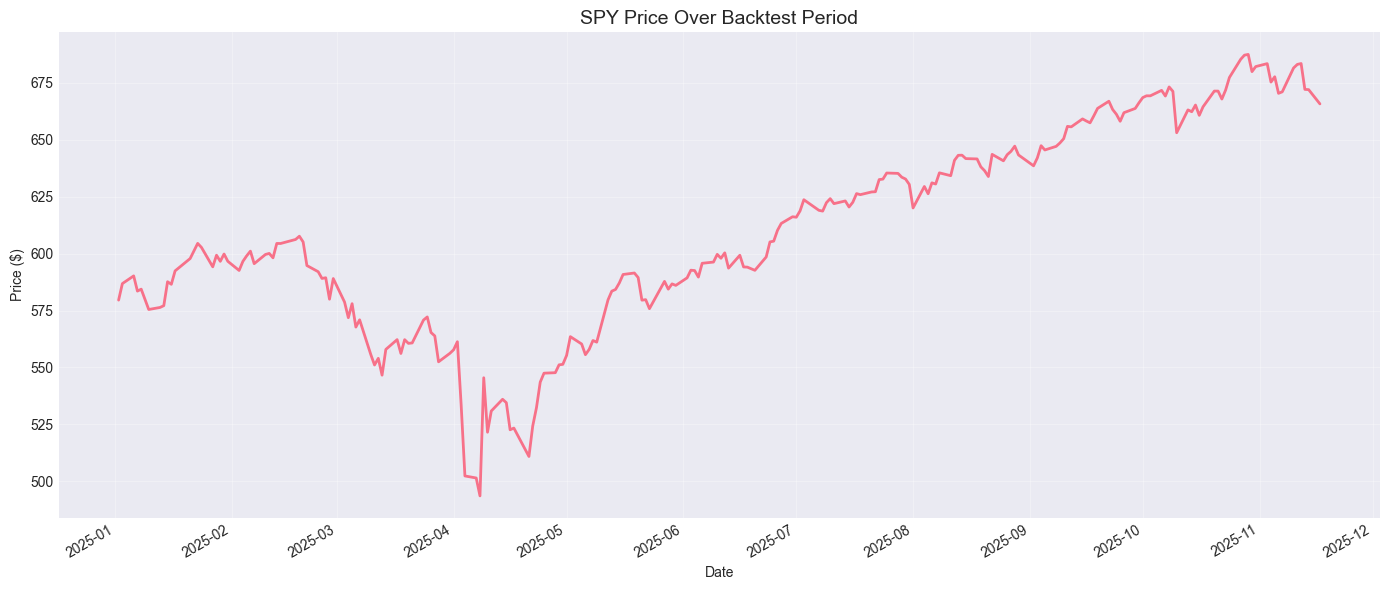

In [6]:
# Plot SPY price
fig, ax = plt.subplots(figsize=(14, 6))
underlying_data['close'].plot(ax=ax, linewidth=2)
ax.set_title('SPY Price Over Backtest Period', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Explore options data structure
sample_date = options_data['quote_date'].iloc[0]
sample_expiration = options_data['expiration'].iloc[0]

sample_chain = options_data[
    (options_data['quote_date'] == sample_date) &
    (options_data['expiration'] == sample_expiration)
]

print(f"Sample options chain for {sample_date.date()}")
print(f"Expiration: {sample_expiration.date()}")
print(f"DTE: {sample_chain['dte'].iloc[0]}")
print(f"\nNumber of strikes: {sample_chain['strike'].nunique()}")
print(f"\nSample chain:")
sample_chain.sort_values('strike').head(10)

Sample options chain for 2025-01-02
Expiration: 2025-01-10
DTE: 7

Number of strikes: 41

Sample chain:


,quote_date,underlying_symbol,underlying_price,vix,iv_percentile,expiration,dte,strike,option_type,bid,ask,last,volume,open_interest,iv,delta,abs_delta,gamma,theta,vega
0,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,480.0,call,98.77,1.01e+02,9.98e+01,150,17635,0.18,1.00e+00,1.00e+00,6.69e-15,-2.88e-02,7.73e-14
1,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,480.0,put,0.01,2.30e-14,2.28e-14,4171,16362,0.18,-1.24e-14,1.24e-14,6.69e-15,-9.84e-14,7.73e-14
2,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,485.0,call,93.82,9.57e+01,9.48e+01,4074,12520,0.18,1.00e+00,1.00e+00,1.48e-13,-2.93e-02,1.70e-12
3,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,485.0,put,0.01,5.65e-13,5.59e-13,3103,999,0.18,-2.89e-13,2.89e-13,1.48e-13,-2.17e-12,1.70e-12
4,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,490.0,call,88.87,9.07e+01,8.98e+01,4527,600,0.18,1.00e+00,1.00e+00,2.66e-12,-2.98e-02,3.07e-11
5,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,490.0,put,0.01,1.14e-11,1.13e-11,4806,1986,0.18,-5.52e-12,5.52e-12,2.66e-12,-3.91e-11,3.07e-11
6,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,495.0,call,83.93,8.56e+01,8.48e+01,4503,5678,0.18,1.00e+00,1.00e+00,3.93e-11,-3.04e-02,4.54e-10
7,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,495.0,put,0.01,1.89e-10,1.87e-10,2236,19582,0.18,-8.66e-11,8.66e-11,3.93e-11,-5.78e-10,4.54e-10
8,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,500.0,call,78.98,8.06e+01,7.98e+01,1841,10099,0.18,1.00e+00,1.00e+00,4.80e-10,-3.09e-02,5.54e-09
9,2025-01-02 12:00:00,SPY,579.56,17.93,50.0,2025-01-10,7,500.0,put,0.01,2.61e-09,2.58e-09,3386,8683,0.18,-1.12e-09,1.12e-09,4.80e-10,-7.05e-09,5.54e-09


## Run Backtest - Bull Put Spread

The Bull Put Spread is a credit spread strategy:
- **Setup:** Sell higher strike put, buy lower strike put
- **Max Profit:** Premium collected
- **Max Loss:** Strike width - premium
- **Outlook:** Neutral to bullish

In [8]:
# Initialize Bull Put Spread strategy
bull_put_config = config['strategies']['bull_put_spread']
bull_put_strategy = BullPutSpread(bull_put_config)

print(f"Strategy: {bull_put_strategy.name}")
print(f"Entry config: {bull_put_strategy.entry_config}")
print(f"Exit config: {bull_put_strategy.exit_config}")

Strategy: Bull Put Spread
Entry config: {'dte_min': 30, 'dte_max': 45, 'short_delta': 0.3, 'long_delta': 0.1, 'iv_percentile_min': 30, 'iv_percentile_max': 80}
Exit config: {'profit_target': 0.5, 'stop_loss': 0.5, 'dte_min': 21}


In [9]:
# Run backtest
backtester = OptopsyBacktester(config)

print("Running backtest...")
results = backtester.run_backtest(
    strategy=bull_put_strategy,
    options_data=options_data,
    underlying_data=underlying_data
)

# Print results
backtester.print_results(results)

Running backtest...
Running backtest for Bull Put Spread
Config period: 2025-01-03 to 2025-11-17
Actual period: 2025-01-03 to 2025-11-17
Initial capital: $10,000.00
Trading days: 219

BACKTEST RESULTS: Bull Put Spread
Initial Capital:    $10,000.00
Final Value:        $12,471.82
Total Return:       24.72%
Max Drawdown:       -6.70%
Sharpe Ratio:       1.46

Total Trades:       112
Win Rate:           33.93%
Avg Win:            $155.90
Avg Loss:           $-42.72
Profit Factor:      3.65

--- Daily Entry Statistics ---
Total Trading Days:       217
Days with Entry:          112 (51.6%)
Days No Entry:            105
  - No entry signal:      105
  - Max positions reached: 0



## Bull Put Spread Optimization

In [10]:
# Create custom optimizer
optimizer = ParameterOptimizer(
    strategy_type='vertical',
    strategy_class=BullPutSpread,
    backtester=backtester,
    options_data=options_data,
    underlying_data=underlying_data,
    base_config=config
)

# Define custom parameter ranges 
optimizer.set_parameter_range('dte', min=20, max=50, step=5)
# optimizer.set_parameter_range('short_delta', min=0.20, max=0.60, step=0.1)
# optimizer.set_parameter_range('long_delta', min=0.10, max=0.60, step=0.05)
# optimizer.set_parameter_range('profit_target', min=0.15, max=0.50, step=0.05)
optimizer.set_parameter_range('stop_loss', min=-0.70, max=-0.30, step=0.10)
optimizer.set_parameter_range('dte_min', min=1, max=25, step=1)
optimizer.set_parameter_range('iv_percentile', min=10, max=110, step=10)

# Run optimization
results = optimizer.run_optimization(optimization_metric='sharpe_ratio')

# Resume optimization where previous optimization left off
# results = optimizer.run_optimization(
#     resume_from='optimization_checkpoints/BullPutSpread_20250123_143022.csv'
# )

# Analyze results
best = optimizer.get_best_parameters(metric='sharpe_ratio', top_n=5)
print(best)

Set parameter 'dte': 7 values from 20 to 50 (step=5)
Set parameter 'stop_loss': 5 values from -0.7 to -0.3 (step=0.1)
Set parameter 'dte_min': 25 values from 1 to 25 (step=1)
Set parameter 'iv_percentile': 11 values from 10 to 110 (step=10)

PARAMETER OPTIMIZATION: VERTICAL SPREADS
Strategy: BullPutSpread
Parameters to optimize: ['dte', 'stop_loss', 'dte_min', 'iv_percentile']
Total combinations: 9,625
Optimization metric: sharpe_ratio


ESTIMATING RUNTIME...
Running 3 sample backtests to estimate time...



Sampling: 100%|██████████| 3/3 [00:04<00:00]



RUNTIME ESTIMATE
Sample backtests: 3
Average time per backtest: 1.59 seconds
Time range: 1.53s - 1.65s

Total combinations: 9,625

Estimated total runtime:
  Best case:  4.1 hours
  Average:    4.2 hours
  Worst case: 4.4 hours




✓ Starting optimization...


💾 Checkpoint file: optimization_checkpoints/BullPutSpread_20251125_084755.csv
    Saving every 10 combinations


Optimizing BullPutSpread:  46%|████▌     | 4406/9625 [2:01:26<2:23:51,  1.65s/combo]   




⚠️  Interrupted by user (Ctrl+C)
💾 Saving checkpoint before exit...
    💾 Checkpoint saved: 4406 results → BullPutSpread_20251125_084755.csv

To resume later, use:
  results = optimizer.run_optimization(
      resume_from='optimization_checkpoints/BullPutSpread_20251125_084755.csv'
  )


KeyboardInterrupt: 

## Run Backtest - Call Calendar Spread

The Call Calendar Spread is a time-based debit spread strategy:
- **Setup:** Sell near-term call (e.g., 30 DTE), buy far-term call (e.g., 60 DTE) at same strike
- **Max Profit:** When underlying is at strike at near-term expiration
- **Max Loss:** Net debit paid
- **Outlook:** Neutral to slightly bullish, expect low volatility
- **Exit:** Must exit before near-term expiration, plus profit/loss targets

In [ ]:
# Initialize Call Calendar strategy
call_calendar_config = config['strategies']['call_calendar']
call_calendar_strategy = CallCalendarSpread(call_calendar_config)

print(f"Strategy: {call_calendar_strategy.name}")
print(f"Entry config: {call_calendar_strategy.entry_config}")
print(f"Exit config: {call_calendar_strategy.exit_config}")

In [ ]:
# Run backtest
backtester = OptopsyBacktester(config)

print("Running backtest...")
results = backtester.run_backtest(
    strategy=call_calendar_strategy,
    options_data=options_data,
    underlying_data=underlying_data
)

# Print results
backtester.print_results(results)

# Export results
backtester.export_trades(results, format = 'xlsx')

## Call Calendar Optimization

In [ ]:
# Create custom optimizer
optimizer = ParameterOptimizer(
    strategy_type='calendar',
    strategy_class=CallCalendarSpread,
    backtester=backtester,
    options_data=options_data,
    underlying_data=underlying_data,
    base_config=config
)

# Define custom parameter ranges 
optimizer.set_parameter_range('near_dte', min=20, max=35, step=5)
optimizer.set_parameter_range('far_dte', min=45, max=75, step=10)
optimizer.set_parameter_range('target_delta', min=0.40, max=0.60, step=0.05)
optimizer.set_parameter_range('profit_target', min=0.15, max=0.40, step=0.05)
optimizer.set_parameter_range('stop_loss', min=-0.70, max=-0.30, step=0.10)
optimizer.set_parameter_range('dte_exit', min=1, max=15, step=1)
optimizer.set_parameter_range('iv_percentile', min=10, max=80, step=10)

# Run optimization
results = optimizer.run_optimization(optimization_metric='sharpe_ratio')

# Analyze results
best = optimizer.get_best_parameters(metric='sharpe_ratio', top_n=5)
print(best)

### Custom Parameter Optimization

For more control over the optimization process, you can manually configure parameter ranges:

```python
# Create custom optimizer
optimizer = ParameterOptimizer(
    strategy_type='calendar',
    strategy_class=CallCalendarSpread,
    backtester=backtester,
    options_data=options_data,
    underlying_data=underlying_data,
    base_config=config
)

# Define custom parameter ranges (simplified syntax)
# Single 'near_dte' and 'far_dte' parameters instead of separate min/max
optimizer.set_parameter_range('near_dte', min=20, max=35, step=5)
optimizer.set_parameter_range('far_dte', min=45, max=75, step=10)
optimizer.set_parameter_range('target_delta', min=0.40, max=0.60, step=0.05)
optimizer.set_parameter_range('profit_target', min=0.15, max=0.40, step=0.05)
optimizer.set_parameter_range('stop_loss', min=-0.70, max=-0.30, step=0.10)
optimizer.set_parameter_range('dte_exit', min=3, max=10, step=2)

# Run optimization
results = optimizer.run_optimization(optimization_metric='sharpe_ratio')

# Analyze results
best = optimizer.get_best_parameters(metric='sharpe_ratio', top_n=5)
print(best)
```

**Simplified Parameter Syntax:**
- **Calendar spreads**: Use `near_dte` and `far_dte` (single target values)
- **Vertical spreads**: Use `dte` (sets both dte_min and dte_max to same value)
- This reduces parameter combinations and makes more sense for strategy logic

**Warning:** More parameters = exponentially more combinations! 
- 6 parameters with 4 values each = 4,096 backtests
- Each backtest may take 5-30 seconds depending on data size

## Performance Analysis

In [ ]:
# Create performance analyzer
analyzer = PerformanceAnalyzer(
    equity_curve=results['equity_curve'],
    trades=results['trades']
)

# Calculate all metrics
metrics = analyzer.calculate_all_metrics(config['backtest']['initial_capital'])

# Print detailed report
report = analyzer.generate_report(metrics)
print(report)

In [ ]:
# Plot equity curve
analyzer.plot_equity_curve(figsize=(14, 6))

In [ ]:
# Plot drawdown
analyzer.plot_drawdown(figsize=(14, 6))

In [ ]:
# Plot monthly returns
analyzer.plot_monthly_returns(figsize=(14, 6))

In [ ]:
# Plot trade distribution
analyzer.plot_trade_distribution(figsize=(14, 5))

In [ ]:
# Plot open positions over time
analyzer.plot_open_positions(figsize=(14, 6))

## Trade Analysis

In [ ]:
# Examine individual trades
trades_df = results['trades']

print("Top 10 winning trades:")
print(trades_df.nlargest(10, 'net_pnl')[['entry_date', 'exit_date', 'net_pnl', 'days_in_trade', 'exit_reason']])

In [ ]:
print("Top 10 losing trades:")
print(trades_df.nsmallest(10, 'net_pnl')[['entry_date', 'exit_date', 'net_pnl', 'days_in_trade', 'exit_reason']])

In [ ]:
# Exit reason analysis
print("Exit reasons breakdown:")
exit_reasons = trades_df['exit_reason'].str.split(':', expand=True)[0].value_counts()
print(exit_reasons)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
exit_reasons.plot(kind='bar', ax=ax)
ax.set_title('Trade Exit Reasons')
ax.set_xlabel('Exit Reason')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Compare Multiple Strategies

Run backtests for all enabled vertical and calendar spread strategies and compare their performance side-by-side.

In [ ]:
# Run all enabled strategies
all_results = {}

strategies = [
    ('Bull Put Spread', BullPutSpread, 'bull_put_spread'),
    ('Bear Call Spread', BearCallSpread, 'bear_call_spread'),
    ('Call Calendar Spread', CallCalendarSpread, 'call_calendar'),
    ('Put Calendar Spread', PutCalendarSpread, 'put_calendar'),
]

for name, StrategyClass, config_key in strategies:
    if config['strategies'][config_key]['enabled']:
        print(f"\nRunning {name}...")
        strategy = StrategyClass(config['strategies'][config_key])
        backtester = OptopsyBacktester(config)
        
        results = backtester.run_backtest(
            strategy=strategy,
            options_data=options_data,
            underlying_data=underlying_data
        )
        
        all_results[name] = results
        backtester.print_results(results)

In [ ]:
# Compare strategies
comparison = []

for name, results in all_results.items():
    comparison.append({
        'Strategy': name,
        'Total Return %': results['total_return_pct'],
        'Sharpe Ratio': results['sharpe_ratio'],
        'Max DD %': results['max_drawdown_pct'],
        'Win Rate %': results['win_rate_pct'],
        'Trades': results['total_trades'],
        'Profit Factor': results['profit_factor']
    })

comparison_df = pd.DataFrame(comparison)
print("\n" + "="*80)
print("STRATEGY COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

## Parameter Optimization (Optional)

Test different parameter combinations to find optimal settings for each strategy.

**Parameters to optimize:**
- Entry DTE ranges (30-45, 20-35, etc.)
- Delta targets (0.20, 0.30, 0.40 for vertical spreads)
- Strike widths (5, 10, 15 points)
- Profit targets (25%, 50%, 75% of max profit/debit)
- Stop losses (50%, 75%, 100% of max loss/debit)
- Calendar spread DTE combinations (30/60, 20/50, etc.)

**Methods:**
1. Grid search across parameter ranges
2. Walk-forward optimization
3. Monte Carlo simulation

*Note: This section is left as future enhancement. Add optimization loops below.*

## Next Steps

1. **Understand Exit Criteria**
   - Read README.md "Exit Criteria Explained" section
   - Learn how profit targets and stop losses work (% based)
   - Understand differences between credit/debit spreads and calendar spreads

2. **Generate More Data**
   - Run `python generate_synthetic_data.py` for 2+ years of data
   - Or integrate real data from OptionsDX / Polygon.io
   - See GETTING_STARTED.md "Understanding the Data Strategy" section

3. **Refine Strategies**
   - Test different profit targets (25%, 50%, 75%)
   - Test different stop losses (25%, 50%, 75%)
   - Add market filters (VIX, IV rank)
   - Test different delta targets and DTE ranges
   - Optimize entry/exit parameters

4. **Compare Vertical vs Calendar Spreads**
   - Vertical spreads: Direction-based, profit from price movement
   - Calendar spreads: Time-based, profit from time decay differential
   - Test both in different market conditions (trending vs ranging)

5. **Add More Strategies**
   - Iron Condors (combining bull put + bear call)
   - Iron Butterflies
   - Straddles/Strangles

6. **Live Trading Preparation**
   - Integrate Schwab API for paper trading
   - Add real-time monitoring
   - Implement risk management alerts
   - Use real options data for final validation